# Text classification with linear models (binary classification)

# Introduction

**Text classification**, broadly, is the process of categorizing text into pre-defined groups/classes. In practice, text classification looks like a laundry list of common applied tasks:
- Sentiment Analysis, or understanding the view / attitude / feeling / emotion towards a situation or event expressed in a text;
- Topic Labeling, or identifying the theme or topic present in the text (e.g. analyzing the topics of news articles)
- Spam detection, or determining whether a message (often email) is spam or not.
- User attribute inference, or guessing the gender, age, occupation, author, or other factors based on their posts on social media platforms.

Text classification methods let us **organize unstructured text** to extract value from or gain insights into it. They're commonly deployed on a wide variety of corpuses:
- social media messages
- emails
- online conversations (chat-bots)
- websites
- any other text data that could reasonably have categories!

Modern text classification methods use a machine learning approach in which we
1. train a classifier using pre-labeled data
2. test the classifier on held out data, and then
3. apply the classifier to make predictions on un-labeled data.

This approach is nice in that it is fast, effective, and accurate, but it does require a significant amount of pre-labeled training data.

    
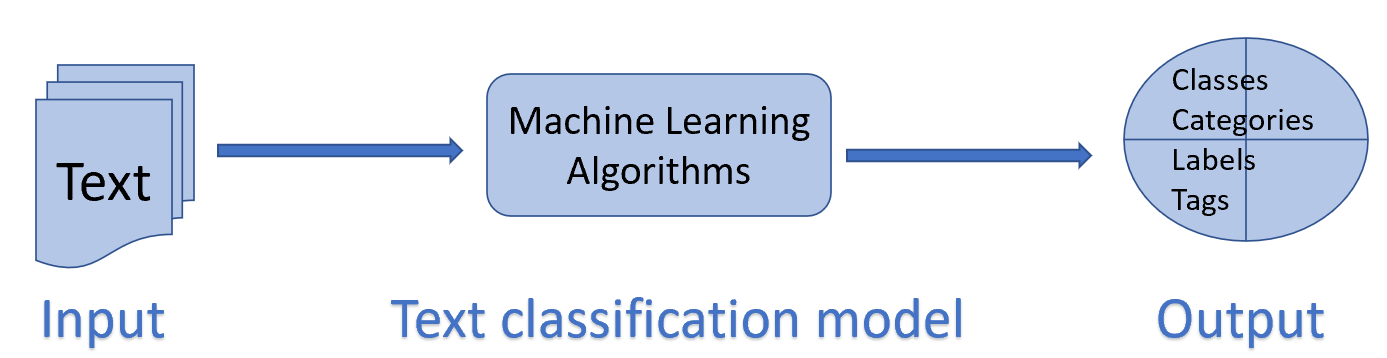

<br>


# Overview
In this assignment, we will practice building a machine learning system for binary sentiment classification of [IMDb](https://www.imdb.com/) movie reviews with the following guided tasks:

In tasks Tasks 1 and 2, we will explore different text representation techniques: <br>
- **Task-1**: exploring text representation with `TfidfVectorizer` <br>
- **Task-2**: exploring text representation with embedding techniques (choose from [word2vec](https://www.cell.com/heliyon/fulltext/S2405-8440(18)35340-4) and OpenAI) <br>

In Tasks 3 and 4, we will explore different parameter settings for our linear models: <br>
- **Task-3**: comparing model performance with `penalty='l1'` VS `penalty='l2'` <br>
- **Task-4**: exploring model performance with `C=0.1` VS `C=1` VS `C=10` <br>

Lastly, in **Task 5** you will choose the best model from your exploration and conduct **error analysis** to understand and explain where the model fails <br>

# Data
The dataset contains 50,000 IMDB movie reviews with an indicator for the sentiment ("positive" or "negative") of the review. More details can be found from the following resources:
- [Data source](https://ai.stanford.edu/~amaas/data/sentiment/) <br>
- [Paper: Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) <br>
- Example review: https://www.imdb.com/title/tt0454921/reviews?ref_=tt_urv

In [1]:
import time, os

# scientific calculation packages
import numpy as np
import pandas as pd
from collections import Counter

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# natural language processing packages
import re
from nltk.corpus import stopwords

# machine learning packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Exploratory Data Analysis

In [2]:
# Read data from csv file to a pandas dataframe
df_data = pd.read_csv('./IMDB Dataset.csv') # change to your path

# check the data size and display the top-n data samples
df_data.shape, display(df_data.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


((50000, 2), None)

**Note**: You can change parameter setting to view non-truncated dataframe with:
>```Python
pd.set_option('display.max_colwidth', None)
>```

In [3]:
# an example of a negative review
df_data.iloc[10].sentiment, df_data.iloc[10].review

('negative',
 'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"')

Check **missing** values

In [4]:
df_data.isnull().sum()

review       0
sentiment    0
dtype: int64

Remove **duplicate** samples

In [5]:
df_data = df_data.drop_duplicates(keep="first")

# check the number of training samples after remove duplication
# reduce from 50,000 to 49582, we removed about 500 duplicate samples
df_data.shape

(49582, 2)

## Explore the target variable

Target variable: sentiment

Check the **distribution** of the target variable.

<Axes: xlabel='sentiment'>

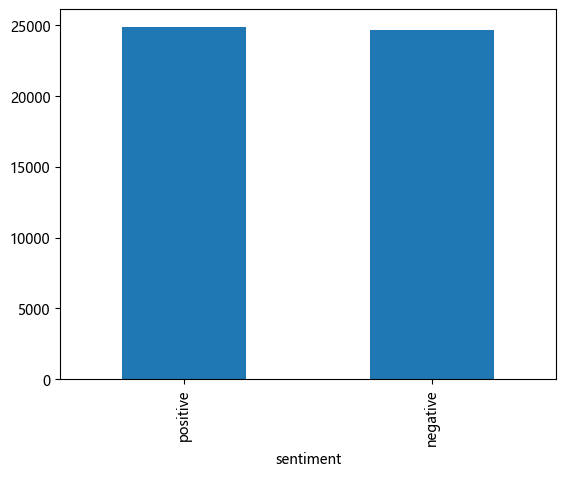

In [6]:
df_data.sentiment.value_counts().plot(kind='bar')

The dataset is **equally distributed (balanced)**, which is great for building a ML model.

Next, we will convert the **sentiment labels to binary values** (e.g., 1 for postive and 0 for negative).

In [7]:
df_data['label'] = df_data['sentiment'].map({'positive':1,'negative':0})
df_data.head()[['review','sentiment','label']]

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


## Explore the feature variables

Let's first check the **length** of the reviews (a common exploration for text data)

In [8]:
df_data['length'] = df_data['review'].apply(len) # number of characters
df_data['length'].describe()
# the describe function shows the mean, std, min, max of length of the reviews

count    49582.000000
mean      1310.568230
std        990.762238
min         32.000000
25%        699.000000
50%        971.000000
75%       1592.000000
max      13704.000000
Name: length, dtype: float64

In [9]:
# Add a new column 'length' to the dataframe
df_data.head(2)

,review,sentiment,label,length
0,One of the other reviewers has mentioned that ...,positive,1,1761
1,A wonderful little production. <br /><br />The...,positive,1,998


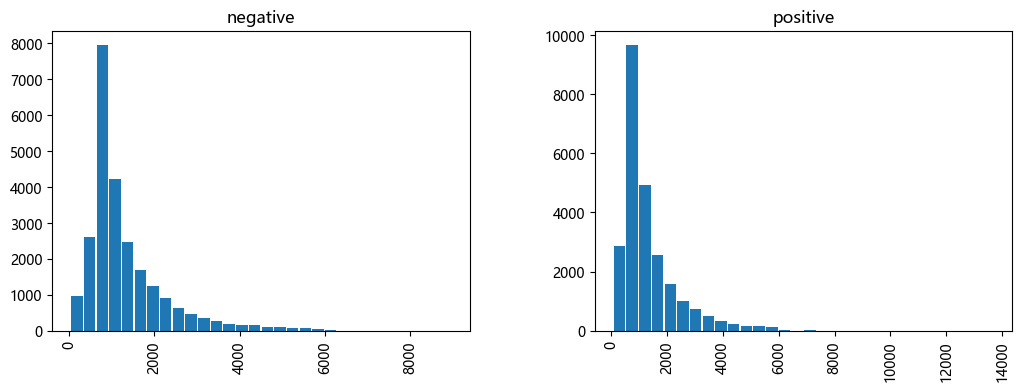

In [10]:
# check the length distribution of positive and negative reviews
# x: length of reviews; y: number of reviews fall into each interval
df_data.hist(column='length', by='sentiment',bins=30, figsize=(12,4),
             rwidth=0.9)
plt.show()

The distribution plot shows that there is no clear difference between postive and negative reviews in terms of length.

We now have a basic understanding of the dataset after the initial exploration; let's go ahead and process the reviews.

### Text Data Preprocessing
There are a large variety of potential text data preprocessing steps, including but not necessarily limited to:
- text cleaning (e.g., removing special characters, emails, urls)
- lowercasing (e.g., Happy New Year -> happy new year)
- removing stopwords
- stemming, or choping off the ends of words to transform words into their root forms (e.g., connected->connect)
- lemmatization, or mapping a word to its root form (e.g., interesting -> interest)
- normalization, or transforming a text into a standard form (abbreviations, misspellings, out-of-vocabulary words; e.g., gooood->good)
- part-of-speech tagging (e.g., good -> ADJ)


For our task of analyzing IMDb movie reviews data, we mainly focus on **text cleaning**, such as removing:

> HTML tags <br>
> special / non-alphabetic characters <br>
> url <br>
> emails <br>

In [11]:
# Here is an example of the review that need further cleaning.
df_data.review[5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [12]:
from tqdm import tqdm
import re, string
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer

We define two functions to **clean** the text data:

In [13]:
def decontracted(phrase):
    """
    Expand contractions into normal words
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase) # prime
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def clean_text(df):
    """
    Clean the review texts
    """
    cleaned_review = []

    for review_text in tqdm(df['review']):

        # expand contractions
        review_text = decontracted(review_text)

        # remove html tags
        review_text = BeautifulSoup(review_text, 'lxml').get_text().strip() # re.sub(r'<.*?>', '', text)

        # remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)

        # remove url
        review_text = re.sub(r'https?://\S+|www\.\S+', '', review_text)

        # Removing punctutation, string.punctuation in python consists of !"#$%&\'()*+,-./:;<=>?@[\\]^_{|}~`
        review_text = review_text.translate(str.maketrans('', '', string.punctuation))
        # ''.join([char for char in movie_text_data if char not in string.punctuation])

        # remove emails
        review_text = re.sub(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", '', review_text)

        cleaned_review.append(review_text)

    return cleaned_review

In [14]:
df_data['cleaned_review'] = clean_text(df_data)

df_data.head()[['review', 'cleaned_review', 'sentiment', 'label']]

100%|██████████| 49582/49582 [00:11<00:00, 4332.50it/s]


,review,cleaned_review,sentiment,label
0,One of the other reviewers has mentioned that ...,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,A wonderful little production The filming tec...,positive,1
2,I thought this was a wonderful way to spend ti...,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,Basically there is a family where a little boy...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",Petter Mattei is Love in the Time of Money i...,positive,1


In [15]:
# a review before and after cleaning, we can see that the punctuations and html tags are removed.

print(df_data['review'][9],'\n')

print(df_data['cleaned_review'][9])

If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!! 

If you like original gut wrenching laughter you will like this movie  If you are young or old then you will love this movie  hell even my mom liked it Great Camp   


### Text Data Representation

After cleaning the text data, we will transform it into numerical feature vectors that computers can understand (see the [sklearn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) for more). Recall from class that we have multiple possible **units of representation**, such as individual words, ngrams/phrases, or sentences. Additionally recall the three vectorization methods we discussed:

- **`CountVectorizer`**: if we consider documents to be a bag of words with no order or context, we can just represent each document as a vector of word counts.
- **`TfidfVectorizer`**: if we consider documents to be a bag of words with no order or context, then we may think that the words that appear often in a given document but which appear rarely across all documents are highly salient. `TfidfVectorizer`'s formalize this by dividing the term-frequency of a word in a given document by it's frequency across all documents.
- **`Embeddings`**: Embeddings represent words as high-dimensional dense vectors which take into account the context and relative order of words. There are numerous ways to get embedding representations, such as word2vec, BERT, and GPT.   

In the following section, we'll walk through transforming text with a **`CountVectorizer`** ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [16]:
# we can check the pre-defined English stop words list
# print(stopwords.words('english'))

In [17]:
# we define your own stopwords list as the pre-defined one is not enough
# Note that we exclude NO, NOR, NOT from the stop words as they play a key role
stopwords= list(set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]))


In [18]:
# In the CountVectorizer, we ask it to lowercase the text and to use a self-defined stopwords list to remove stopwords
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.9, min_df=3, ngram_range=(1,1))

# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(df_data.cleaned_review)
# X is a 2-d matrix of vector representation of the cleaned reviews

print("X.shape : ",X.shape)
# X.shape: the number of samples, the number of features (size of vocabulary)

X.shape :  (49582, 47192)


Here is an example of the CountVectorizer representation for a movie review: it is represented as a vector of 47,352 elements, but only 136 of them are non-zero. That's incredibly **sparse**!

In [19]:
X[0]

<1x47192 sparse matrix of type '<class 'numpy.int64'>'
	with 136 stored elements in Compressed Sparse Row format>

## Finalize the feature matrix
We prepare the feature matrix for model training by:
1. Splitting the data into training and testing with 80:20 ratio (you can customize the ratio) and **shuffling** the data at the same time (random permutations of the collections)
2. Assigning **a random state of 42 for reproducible output**

In [20]:
# Define the target variable: sentiment labels
y = df_data.label.values

print("y.shape : ",y.shape)

y.shape :  (49582,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                 shuffle=True,
                                                 random_state=42)
# check data size after splitting
print("Training data: X : {}, y : {}".format(X_train.shape, y_train.shape))
print("Testing data: X : {}, y : {}".format(X_test.shape, y_test.shape))
# After train test split, we get 39,665 samples in the training set and 9,917 samples in the testing set.

Training data: X : (39665, 47192), y : (39665,)
Testing data: X : (9917, 47192), y : (9917,)


In [22]:
# check data distribution in train and test

print("Training data distribution", Counter(y_train))
print("Testing data distribution", Counter(y_test))

Training data distribution Counter({1: 19906, 0: 19759})
Testing data distribution Counter({1: 4978, 0: 4939})


An **alternative choice** if you want to track the train and test index (we will need the index information for **error analysis**)

In [23]:
# Instead of splitting our data itself, split indices into either training rows
# or testing rows.
train_idx, test_idx = train_test_split(np.arange(df_data.shape[0]), test_size=0.2,
                                       shuffle=True, random_state=42)

len(train_idx), len(test_idx)
print("Number of training examples:{}".format(len(train_idx)))
print("Number of testing examples:{}".format(len(test_idx)))

Number of training examples:39665
Number of testing examples:9917


In [24]:
# And then use these indices to split our data directly
X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

print("Training data: X_train : {}, y_train : {}".format(X_train.shape, y_train.shape))
print("Testing data: X_test : {}, y_test : {}".format(X_test.shape, y_test.shape))

Training data: X_train : (39665, 47192), y_train : (39665,)
Testing data: X_test : (9917, 47192), y_test : (9917,)


# Model training and testing

In this section, we will:
- apply a Logistic Regression model to fit on the training data <br>
- evaluate its performance on the testing data or cross-validate the model performance on the whole dataset <br>
    - **quantitative** evaluation with precision, recall, f1, roc_auc <br>
    - **qualitative** evaluation with important features <br>

In [25]:
# Create a LogisticRegression classifier
lr_clf = LogisticRegression(penalty='l2')

In [26]:
# Fit the model on training data
lr_clf.fit(X_train, y_train)

LogisticRegression()

**Evaluate** the model performance on testing set

In [27]:
# with the "score" function (accuracy score)
# Round it to the 3rd decimal (e.g., 0.800, 0.850, 0.862).
float("{:.3f}".format(lr_clf.score(X_test, y_test)))

0.883

Alternatively, we can **cross-validate** model performance with the whole dataset. In brief, when cross-validating we:
- split data into k folds <br>
- train on k-1 folds, test on 1 fold, repeat k times (each sample appear once in the test set) <br>
- report model performance for each fold <br>

An example of this process is below.

In [28]:
scores = cross_val_score(lr_clf, X, y, cv=5, scoring='precision')
print(np.round(scores,3))

[0.884 0.88  0.88  0.873 0.889]


## Model evaluation
We haven't fully covered the different [evaluation techniques](https://scikit-learn.org/stable/modules/model_evaluation.html) in the lecture yet, but here we provide a preview of the different methods you might consider for evaluating a classification model.

We use two common **quantitative evaluation** metrics:
- Classification report, which shows us for precision, recall, and f1 <br>
- `roc_auc`, which shows how well the model performs at different confidence thresholds <br>

In [29]:
# apply the fitted model to prediction the label for the test data
y_pred_test = lr_clf.predict(X_test)
y_pred_test

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
# check the predicted probabilities of each test data
y_predprob_test = lr_clf.predict_proba(X_test)
np.round(y_predprob_test, 3)

array([[1.   , 0.   ],
       [0.   , 1.   ],
       [0.987, 0.013],
       ...,
       [1.   , 0.   ],
       [0.998, 0.002],
       [0.854, 0.146]])

In [31]:
print(classification_report(y_test, y_pred_test))
# micro average (averaging the total true positives, false negatives and false positives globally, true pos of one class / (all true pos + all false pos))
# macro average (averaging the unweighted mean per label)

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.88      0.89      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



ROC curve ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html))

In [32]:
from sklearn.metrics import roc_curve, auc

In [33]:
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = y_predprob_test[:,1], pos_label=1)
roc_auc = auc(fpr, tpr) # area under ROC curve

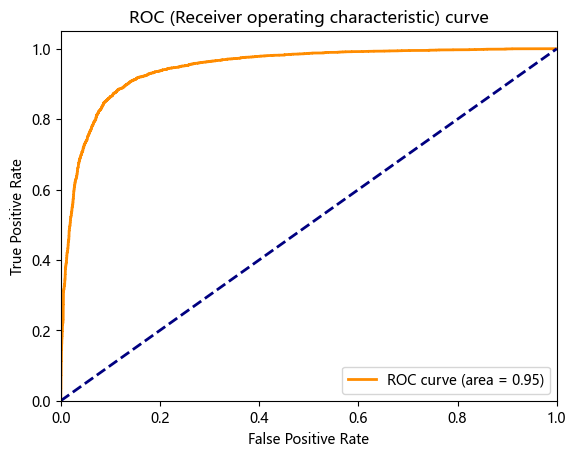

In [34]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (Receiver operating characteristic) curve')
plt.legend(loc="lower right")
plt.show()

According to the evaluation scores we can say that **the model is performing well**, and we will provide detailed explainations in the lecture.

**Qualitative evaluation**:

We will identify the **important features** to validate model integrity in the context of sentiment classification.

In [35]:
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names_out(), lr_clf.coef_[0])}

In [36]:
# Top features that are predictive of positive sentiment
print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('disappoint', 2.053),
 ('refreshing', 2.018),
 ('hooked', 1.805),
 ('superb', 1.589),
 ('wonderfully', 1.528),
 ('underrated', 1.468),
 ('delightful', 1.442),
 ('excellent', 1.438),
 ('entertains', 1.424),
 ('perfect', 1.419)]

In [37]:
# Top features that are predictive of negative sentiment

print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]
# Most of top-10 negative words are reliable evidence of indicating negative sentiments

Top negative features:


[('waste', -2.243),
 ('uninteresting', -2.205),
 ('worst', -2.146),
 ('forgettable', -1.961),
 ('mildly', -1.955),
 ('disappointment', -1.907),
 ('stinker', -1.803),
 ('generous', -1.724),
 ('dreadful', -1.7),
 ('awful', -1.681)]

Most of the top predictive features make sense:
- words like "refreshing, hooked, superb" are typically used to express positive sentiments; <br>
- words like "waste, worst" are typically used to express negative sentiments; <br>

**However**, some positive features like "disappoint, underrated" as well as negative features like "generous", are not clearly correlated with the sentiment. We will explore this further in the **error analysis** section.

# Error analysis

In this section, we will conduct error analysis to identify samples where the model fails to correctly predict the sentiment of a movie review.

In [38]:
df_test = df_data.iloc[test_idx]
df_test['pred_label'] = y_pred_test
df_test.head(3)[['review','label','pred_label']]

,review,label,pred_label
29171,"""Soul Plane"" is a horrible attempt at comedy t...",0,0
43589,Guest from the Future tells a fascinating stor...,1,1
38712,"""National Treasure"" (2004) is a thoroughly mis...",0,0


In [39]:
df_test[df_test['label'] != df_test['pred_label']].head()[['review','label','pred_label']]

,review,label,pred_label
47783,His significant charisma and commanding presen...,0,1
40146,A horror movie is being shot and things aren't...,1,0
42907,There is only one racist joke in this Daffy Du...,1,0
43156,I've been a classic horror fan my entire life....,0,1
8304,I acquired this film a couple of years ago and...,0,1


In [40]:
df_data.loc[47783]['cleaned_review']

'His significant charisma and commanding presence are about all that keep this afloat  but Fred Williamson has done far better urban action films including many of his later  vid released fare  The big studios  Williamson films of the early to mid    is rarely had the punch of their mid level counterparts  and this is a prime example  Clumsy action  little violence  and the PG rating is nowhere near questionable  Worth a look for Hammer completists in any case '

In [41]:
import textwrap

# We'll use colors for convenience of viewing,
# but your implementations do not need to do this.
RED = '\033[1;31;48m'
BLUE = '\033[1;34;48m'
END = '\033[1;37;0m'

def interpretation(text, vectorizer, wrap_length=250, use_color=True):
    """
    Annotate each word feature with the learned coefficient, and color based on
    coefficient direction
    """
    # Make the annotated string
    analysis = []
    for wd in text.split():
        if wd in vectorizer.vocabulary_:
            wd_id = vectorizer.vocabulary_[wd]
            to_append = wd

            # Red is more negative, blue is more positive
            if use_color and lr_clf.coef_[0][wd_id] < 0:
                to_append = RED + to_append + END
            elif use_color and lr_clf.coef_[0][wd_id] > 0:
                to_append = BLUE + to_append + END

            to_append = to_append+'('+("%.3f" % lr_clf.coef_[0][wd_id])+')'


            analysis.append(to_append)
        else:
            analysis.append(wd)
    result = ' '.join(analysis)

    # Wrap the string for easier viewing
    wrapper = textwrap.TextWrapper(width=wrap_length)
    result = wrapper.fill(text=result)

    print(result)


In [42]:
interpretation(df_data.loc[47783]['cleaned_review'],vectorizer)

His significant(-0.149) charisma(0.086) and commanding(0.414) presence(-0.033) are about all that keep(0.352) this afloat(-0.246) but
Fred Williamson has done(-0.083) far(-0.385) better(-0.131) urban(0.653) action(0.124) films(0.029) including(-0.095)
many(-0.028) of his later(0.292) vid(-0.152) released(0.057) fare(0.523) The big(-0.066) studios(0.451) Williamson
films(0.029) of the early(-0.140) to mid(0.609) is rarely(-0.355) had the punch(0.017) of their mid(0.609)
level(0.179) counterparts(0.310) and this is a prime(0.255) example(-0.763) Clumsy action(0.124) little(0.060)
violence(-0.054) and the PG rating(0.001) is nowhere(-0.439) near(-0.078) questionable(0.177) Worth a look(-0.095) for Hammer
completists(-0.299) in any case(-0.123)


# Tasks to complete

In the previous section, we showed how to build a machine learning system for binary sentiment classification. Now it's your turn. In the following sections, you will build a similar model, exploring how different text representation techniques and model parameter settings affect model performance along the way.

#### **Task-1**: Text Representation with $TfidfVectorizer$

In our example, we represented text with $CountVectorizer$. In this task, you will use a `TfidfVectorizer` to represent text as numeric data, before training a model and evaluating its performance. Specifically, you will:
- Repeat our `CountVectorizer` feature creation process, but instead using a  `TfidfVectorizer` to create the feature matrix. Use the same parameter settings from our analysis.
- **$fit$** a LogisticRegression classifier with the default parameter setting
- Evaluate model performance based on the **$classification\_report$**
- Print the top-10 positive and negative features
- Compare the model performance and top-n features with the previous results using `CountVectorizer`

In [43]:
# import TfidfVectorizer method
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
# lowercase the text and to use the previous self-defined stopwords list to remove stopwords
vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopwords, max_df=0.9, min_df=3, ngram_range=(1,1))

#convert the cleaned reviews to vectors
X = vectorizer.fit_transform(df_data.cleaned_review)

In [45]:
print("X.shape : ",X.shape)

X.shape :  (49582, 47192)


In [46]:
# import train_test_split
from sklearn.model_selection import train_test_split

In [47]:
# define the target variable: sentiment labels
y = df_data.label.values

In [48]:
print("y.shape : ",y.shape)

y.shape :  (49582,)


In [49]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [50]:
# check the train and test data numbers
print("Training data: X : {}, y : {}".format(X_train.shape, y_train.shape))
print("Testing data: X : {}, y : {}".format(X_test.shape, y_test.shape))

Training data: X : (39665, 47192), y : (39665,)
Testing data: X : (9917, 47192), y : (9917,)


In [51]:
# check the data distribution
print("Training data distribution", Counter(y_train))
print("Testing data distribution", Counter(y_test))

Training data distribution Counter({1: 19906, 0: 19759})
Testing data distribution Counter({1: 4978, 0: 4939})


In [52]:
# import the LogisticRegression model
from sklearn.linear_model import LogisticRegression

In [53]:
# initialize the Logistic Regression classifier
lr_clf = LogisticRegression(penalty='l2')

# fit model to train data
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [54]:
# evaluate the model performance
float("{:.3f}".format(lr_clf.score(X_test, y_test)))

0.897

In [55]:
# import classification_report
from sklearn.metrics import classification_report

In [56]:
# Use the fitted model to predict labels on the test dataset
y_pred_test = lr_clf.predict(X_test)

In [57]:
# check the classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4939
           1       0.88      0.91      0.90      4978

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



In [58]:
# match each feature with its corresponding weight in the model 
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names_out(), lr_clf.coef_[0])}

In [59]:
# get top features that are predictive of positive sentiment
print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('great', 8.115),
 ('excellent', 7.373),
 ('best', 5.642),
 ('perfect', 5.529),
 ('wonderful', 5.354),
 ('amazing', 5.248),
 ('loved', 4.966),
 ('brilliant', 4.698),
 ('well', 4.519),
 ('favorite', 4.434)]

In [60]:
# get top features that are predictive of negative sentiment
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('worst', -10.756),
 ('bad', -8.471),
 ('awful', -7.85),
 ('waste', -7.59),
 ('boring', -6.91),
 ('poor', -6.296),
 ('terrible', -6.257),
 ('nothing', -5.772),
 ('horrible', -5.161),
 ('dull', -5.113)]

_Write your comparison of this model and the previous model(s) here_

After comparing some important numbers, I find that the accuracy for the Tfidf model is 0.897, while the CountVectorizer model is 0.883, meaning Tfidf has slightly better accuracy. Similarly, the F1-score for the CountVectorizer model is 0.88, while the Tfidf model achieves 0.90.

In addition to the performance metrics, I also compared the top predictive words. The CountVectorizer model produced some unexpected results, such as "disappoint" being ranked as the top positive feature, which suggests that the CountVectorizer model more easily influenced by the frequency of word appearances.

In contrast, the Tfidf model's top positive and negative words are more reasonable and aligned with sentiment meaning. This may be because TfidfVectorizer considers not only the frequency of a word within a single text, but also its frequency across the entire dataset, which helps highlight the truly important features.

#### **Task-2**: Text Representation with $embeddings$

In this task, you will apply embedding techniques to represent text, train a model, and evaluate its performance. Specifically, you will:
- Replace `CountVectorizer` with an embedding technique (choose one of word2vec or OpenAI) to create the new feature matrix;
    - For `word2vec`, the embedding representation of a sentence is the average embedding representation of all words in the sentence (you can ignore novel words which are not represented in your word2vec embedding space). <br>
    - For openAI, you can directly pass the sentence or paragraph to retrieve its embedding representation. <br>
- **$fit$** a `LogisticRegression` classifier with the default parameter setting
- Evaluate model performance based on the **$classification\_report$**
- Compare the model performance with the previous results using `CountVectorizer` and `TfidfVectorizer` representations.

In [116]:
from gensim.models import KeyedVectors

# Load pre-trained Word2Vec model
# Model source: https://github.com/eyaler/word2vec-slim
# Loading method reference: StackOverflow discussion "How to load a pre-trained Word2vec MODEL File and reuse it?"
# https://stackoverflow.com/questions/39549248/how-to-load-a-pre-trained-word2vec-model-file-and-reuse-it
word2vec_path = './GoogleNews-vectors-negative300-SLIM.bin'
w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [117]:
import gensim
from sklearn.metrics.pairwise import cosine_similarity

In [118]:
# read this article: https://datascience.stackexchange.com/questions/107012/how-to-calculate-the-mean-average-of-word-embedding-and-then-compare-strings-usi
# follow the method described in the article
# in the article, model.vocab is used, but it is removed in the new gensim version, so I replace it with model.key_to_index
def meanEmbeddings(model, words):
    words = [word for word in words if word in model.key_to_index]
    if len(words) >= 1:
        return np.mean(model[words], axis=0)
    else:
        return []

In [119]:
# Convert the cleaned reviews to sentence embeddings
X = []
for review in df_data.cleaned_review:
    words = review.split()
    X.append(meanEmbeddings(w2v_model, words))

X = np.array(X)

# check the number of samples, the number of features
print("X.shape:", X.shape)

X.shape: (49582, 300)


In [120]:
# define the target variable: sentiment labels
y = df_data.label.values

In [121]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [122]:
# check the train and test data numbers
print("Training data: X : {}, y : {}".format(X_train.shape, y_train.shape))
print("Testing data: X : {}, y : {}".format(X_test.shape, y_test.shape))

Training data: X : (39665, 300), y : (39665,)
Testing data: X : (9917, 300), y : (9917,)


In [123]:
# check the data distribution
print("Training data distribution", Counter(y_train))
print("Testing data distribution", Counter(y_test))

Training data distribution Counter({1: 19906, 0: 19759})
Testing data distribution Counter({1: 4978, 0: 4939})


In [124]:
# initialize the Logistic Regression classifier
lr_clf = LogisticRegression()

# fit model to train data
lr_clf.fit(X_train, y_train)

LogisticRegression()

In [125]:
# evaluate the model performance
float("{:.3f}".format(lr_clf.score(X_test, y_test)))

0.828

In [126]:
# Use the fitted model to predict labels on the test dataset
y_pred_test = lr_clf.predict(X_test)

In [127]:
# check the classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      4939
           1       0.83      0.82      0.83      4978

    accuracy                           0.83      9917
   macro avg       0.83      0.83      0.83      9917
weighted avg       0.83      0.83      0.83      9917



_Write your comparison of this model and the previous model(s) here_

After comparing the key performance metrics, it can be seen that the accuracy for the Tfidf model is 0.897, the CountVectorizer model is 0.883, and the Word2Vec model is 0.828. Similarly, the F1-score for the Tfidf model is 0.90, for the CountVectorizer model is 0.88, and for the Word2Vec model is 0.83. Overall, the Tfidf model performs the best among the three.

The CountVectorizer method is relatively simple. It only counts the number of times a word appears in the text, without considering the word’s importance across the whole dataset. As a result, it may give too much weight to some common but uninformative words, which affects its performance.

TfidfVectorizer improves on this by considering not just how often a word appears in a single text, but also how rare it is across the entire dataset. Words that are common everywhere get lower weights, while more distinctive words are emphasized. This helps the Tfidf model achieve better results overall.

Word2Vec represents each word as a 300-dimensional vector based on its meaning. In this task, the sentence embeddings were created by simply averaging all the word vectors in a review. Because of this averaging process, information about the sentence length and the word order was lost. Important details that might help classification were smoothed out, which makes the Word2Vec model performed worse than the other two models.

#### **Task-3**: model performance with **`penalty='l1'`**

In this task, you will explore how the `penalty` parameter affects model performance. Specifically, you will:
- Use the original `CountVectorizer` to create the feature matrix
- **$fit$** a `LogisticRegression` classifier with `penalty='l1'`
- Evaluate model performance to print the **$classification\_report$**
- Print the top-10 positive and negative features
- Compare the model performance and top-n features with the original results (which used `penalty='l2'`)

In [73]:
# lowercase the text and to use the previous self-defined stopwords list to remove stopwords
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.9, min_df=3, ngram_range=(1,1))

In [74]:
# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(df_data.cleaned_review)

In [75]:
print("X.shape : ",X.shape)

X.shape :  (49582, 47192)


In [76]:
# define the target variable: sentiment labels
y = df_data.label.values

In [77]:
print("y.shape : ",y.shape)

y.shape :  (49582,)


In [78]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [79]:
# check data size after splitting
print("Training data: X : {}, y : {}".format(X_train.shape, y_train.shape))
print("Testing data: X : {}, y : {}".format(X_test.shape, y_test.shape))

Training data: X : (39665, 47192), y : (39665,)
Testing data: X : (9917, 47192), y : (9917,)


In [80]:
# check data distribution in train and test
print("Training data distribution", Counter(y_train))
print("Testing data distribution", Counter(y_test))

Training data distribution Counter({1: 19906, 0: 19759})
Testing data distribution Counter({1: 4978, 0: 4939})


In [81]:
# Create a LogisticRegression classifier use L1
lr_clf = LogisticRegression(penalty='l1', solver='liblinear')

In [82]:
# Fit the model on training data
lr_clf.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [83]:
# evaluate the model performance
float("{:.3f}".format(lr_clf.score(X_test, y_test)))

0.883

In [84]:
# Use the fitted model to predict labels on the test dataset
y_pred_test = lr_clf.predict(X_test)

In [85]:
# check the classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4939
           1       0.88      0.89      0.88      4978

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



In [86]:
# match each feature with its corresponding weight in the model 
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names_out(), lr_clf.coef_[0])}

In [87]:
# Top features that are predictive of positive sentiment
print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('warcraft', 3.429),
 ('nitpick', 2.935),
 ('bloodbath', 2.861),
 ('leisen', 2.812),
 ('squirrel', 2.749),
 ('noirish', 2.632),
 ('occurrence', 2.612),
 ('duet', 2.526),
 ('shores', 2.521),
 ('finely', 2.491)]

In [88]:
# Top features that are predictive of negative sentiment
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('shoddy', -3.107),
 ('stinker', -3.021),
 ('depp', -3.004),
 ('edgerton', -2.967),
 ('uninteresting', -2.897),
 ('backdrops', -2.754),
 ('amasterpiece', -2.731),
 ('seaton', -2.684),
 ('unremarkable', -2.684),
 ('lifeless', -2.558)]

_Write your comparison of this model and the previous model(s) here_

After comparing the results, it can be seen that the overall performance of the L1 model is very similar to the L2 model. The accuracy for both the L1 and L2 models is the same. The F1-scores are also the same. So, in terms of performance, there is no major difference between using L1 or L2.

However, when looking at the top predictive features, there is a noticeable difference. The L2 model selected more common and sentiment-related words like "worst," "awful," "excellent," and "perfect" for positive and negative predictions, which makes sense in the context of sentiment analysis. But the L1 model picked some unusual and less common words, such as "warcraft" and "nitpick" for positive sentiment, and "stinker" and "depp" for negative sentiment.

Based on what we learned in class, L2 tends to keep many features and just shrink their weights, so the selected words are more intuitive and general. In contrast, L1 regularization pushes a lot of feature weights to exactly zero. As a result, it may keep rare but highly distinctive words.

**Task-4**: model performance with **`C=0.1` VS `C=1` VS `C=10`**
    
In this task, you will explore how the `C` parameter affects model performance. Specifically, you will:
- Use the original CountVectorizer to create the feature matrix;
- **$fit$** a LogisticRegression classifier with C=0.1 and C=10
- Evaluate model performance to print the **$classification\_report$**
- Print the top-10 positive and negative features
- Compare the model performance and top-n features with the original results from using `C='1'`

In [89]:
# In the CountVectorizer, lowercase the text and to use a self-defined stopwords list to remove stopwords
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords, max_df=0.9, min_df=3, ngram_range=(1,1))

In [90]:
# convert the cleaned reviews to vectors
X = vectorizer.fit_transform(df_data.cleaned_review)

In [91]:
print("X.shape : ",X.shape)

X.shape :  (49582, 47192)


In [92]:
# Define the target variable: sentiment labels
y = df_data.label.values

In [93]:
print("y.shape : ",y.shape)

y.shape :  (49582,)


In [94]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [95]:
# check data size after splitting
print("Training data: X : {}, y : {}".format(X_train.shape, y_train.shape))
print("Testing data: X : {}, y : {}".format(X_test.shape, y_test.shape))

Training data: X : (39665, 47192), y : (39665,)
Testing data: X : (9917, 47192), y : (9917,)


In [96]:
# check data distribution in train and test
print("Training data distribution", Counter(y_train))
print("Testing data distribution", Counter(y_test))

Training data distribution Counter({1: 19906, 0: 19759})
Testing data distribution Counter({1: 4978, 0: 4939})


In [97]:
# Create a LogisticRegression classifier c=0.1
lr_clf = LogisticRegression(penalty='l2', C=0.1)

# Fit the model on training data
lr_clf.fit(X_train, y_train)

LogisticRegression(C=0.1)

In [98]:
# evaluate the model performance
float("{:.3f}".format(lr_clf.score(X_test, y_test)))

0.893

In [99]:
# Use the fitted model to predict labels on the test dataset
y_pred_test = lr_clf.predict(X_test)

In [100]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4939
           1       0.89      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [101]:
# match each feature with its corresponding weight in the model 
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names_out(), lr_clf.coef_[0])}

In [102]:
# Top features that are predictive of positive sentiment
print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('refreshing', 0.908),
 ('excellent', 0.903),
 ('amazing', 0.844),
 ('superb', 0.832),
 ('perfect', 0.82),
 ('hilarious', 0.768),
 ('brilliant', 0.767),
 ('fantastic', 0.742),
 ('loved', 0.739),
 ('enjoyable', 0.729)]

In [103]:
# Top features that are predictive of negative sentiment
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('worst', -1.468),
 ('waste', -1.463),
 ('awful', -1.138),
 ('disappointment', -1.095),
 ('boring', -0.95),
 ('fails', -0.932),
 ('horrible', -0.89),
 ('poorly', -0.882),
 ('disappointing', -0.867),
 ('dull', -0.854)]

In [104]:
# Create a LogisticRegression classifier c=10
lr_clf = LogisticRegression(penalty='l2', C=10)

# Fit the model on training data
lr_clf.fit(X_train, y_train)

LogisticRegression(C=10)

In [105]:
# evaluate the model performance
float("{:.3f}".format(lr_clf.score(X_test, y_test)))

0.875

In [106]:
# Use the fitted model to predict labels on the test dataset
y_pred_test = lr_clf.predict(X_test)

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4939
           1       0.87      0.88      0.88      4978

    accuracy                           0.87      9917
   macro avg       0.88      0.87      0.87      9917
weighted avg       0.88      0.87      0.87      9917



In [107]:
# match each feature with its corresponding weight in the model 
feature_to_coef = {word: float("%.3f" % coef) for word, coef in zip(vectorizer.get_feature_names_out(), lr_clf.coef_[0])}

In [108]:
# Top features that are predictive of positive sentiment
print("Top positive features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:10]

Top positive features:


[('disappoint', 4.422),
 ('refreshing', 4.05),
 ('hooked', 3.717),
 ('wonderfully', 3.356),
 ('delightful', 3.3),
 ('superb', 3.116),
 ('entertains', 3.068),
 ('brilliantly', 2.982),
 ('underrated', 2.877),
 ('flawless', 2.871)]

In [109]:
# Top features that are predictive of negative sentiment
print("Top negative features:")
sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=False)[:10]

Top negative features:


[('uninteresting', -4.629),
 ('mildly', -4.291),
 ('forgettable', -4.078),
 ('stinker', -3.728),
 ('generous', -3.722),
 ('worst', -3.701),
 ('waste', -3.636),
 ('dreadful', -3.537),
 ('unfunny', -3.29),
 ('disappointment', -3.286)]

_Write your comparison of this model and the previous model(s) here_

After comparing the results, it can be seen that when C=0.1, the model accuracy is 0.893 and the F1-score is 0.89. When C=1, the accuracy is 0.883 and the F1-score is 0.88. When C=10, the accuracy is 0.875 and the F1-score is 0.87. Overall, the model with C=0.1 performs slightly better than the models with C=1 and C=10 in terms of accuracy and F1-score.

In addition to the performance metrics, the predictive features were also compared. When C=0.1, the words have smaller weights, and many common and strong sentiment words like "refreshing," "excellent," "worst," and "waste" are selected, and they are semantically reasonable. When C=1, the feature weights become a bit larger, and while most of the top words are still reasonable, some problems appear, such as "disappoint" being selected as a positive feature, which does not fit the sentiment meaning. When C=10, the feature weights become very large (over 4 or -4), showing signs of overfitting. The problem of "disappoint" appearing as a positive feature shows up again, and words like "generous" are selected as negative features, which are not typical sentiment words. However, overall, most selected features still make semantic sense.

**Task-5**: Error analysis for the best model

Pick the best model from the above explorations. Then, in this task, conduct an error analysis to understand and explain where the model fails. From the samples where the model fail, can you identify any patterns to explain the failure?

_NB_: If a `TfidfVectorizer` or `CountVectorizer` model is the best, then you can use our `interpretation` function from above. If they are not, you will try to summarize patterns from highly misclassified documents.

In [110]:
# Here I think the model using TFIDF is the best one based on the previous comparisons.
# To make sure I use the correct TFIDF model, I re-run the model training from the beginning.
# Also, for better error analysis, I split the data by indices first, and then use these indices to split the actual data matrices.

vectorizer = TfidfVectorizer(lowercase=True, stop_words=stopwords, max_df=0.9, min_df=3, ngram_range=(1,1))
X = vectorizer.fit_transform(df_data.cleaned_review)
y = df_data.label.values 

train_idx, test_idx = train_test_split(np.arange(df_data.shape[0]), test_size=0.2, shuffle=True, random_state=42)

X_train = X[train_idx]
y_train = y[train_idx]

X_test = X[test_idx]
y_test = y[test_idx]

lr_clf = LogisticRegression(penalty='l2')
lr_clf.fit(X_train, y_train)

y_pred_test = lr_clf.predict(X_test)

In [111]:
# Briefly check the prediction results
df_test = df_data.iloc[test_idx]
df_test['pred_label'] = y_pred_test
df_test.head(3)[['review','label','pred_label']]

,review,label,pred_label
29171,"""Soul Plane"" is a horrible attempt at comedy t...",0,0
43589,Guest from the Future tells a fascinating stor...,1,1
38712,"""National Treasure"" (2004) is a thoroughly mis...",0,1


In [112]:
# Select reviews where the true label and the predicted label are different
df_test[df_test['label'] != df_test['pred_label']].head()[['review','label','pred_label']]

,review,label,pred_label
38712,"""National Treasure"" (2004) is a thoroughly mis...",0,1
47783,His significant charisma and commanding presen...,0,1
30771,I preface by stating I am a big fan of JJL and...,0,1
35893,"The over-heated plot of ""Bonjour tristesse"" is...",0,1
40146,A horror movie is being shot and things aren't...,1,0


In [113]:
# Grab one misclassified review for further analysis
df_data.loc[40146]['cleaned_review']

'A horror movie is being shot and things are not going well  It is about a masked killer  The director tells off the killer in front of the cast and crew  He goes crazy and kills two people  He is killed himself and the film is never finished  Twelve years later a bunch of film students decide to try and finish it  but there is a curse  People who try and finish it are killed themselves  The students ignore that  Guess what happens next The plot is old hat but this is not bad   for what it is  a low budget slasher film   It is well made with a young and fairly talented young cast  No one is great but no one is terrible either  It also avoids the obligatory  and needless  female nude scenes  It moves quickly  the gore is nice and bloody and the script does not insult your intelligence  Also Molly Ringwald is in this having the time of her life playing a bitchy faded actress No great shakes but not bad at all  I give it a   '

In [114]:
import textwrap

# use colors for convenience of viewing,
RED = '\033[1;31;48m'
BLUE = '\033[1;34;48m'
END = '\033[1;37;0m'

def interpretation(text, vectorizer, wrap_length=250, use_color=True):
    """
    Annotate each word feature with the learned coefficient, and color based on
    coefficient direction
    """
    # Make the annotated string
    analysis = []
    for wd in text.split():
        if wd in vectorizer.vocabulary_:
            wd_id = vectorizer.vocabulary_[wd]
            to_append = wd

            # Red is more negative, blue is more positive
            if use_color and lr_clf.coef_[0][wd_id] < 0:
                to_append = RED + to_append + END
            elif use_color and lr_clf.coef_[0][wd_id] > 0:
                to_append = BLUE + to_append + END

            to_append = to_append+'('+("%.3f" % lr_clf.coef_[0][wd_id])+')'


            analysis.append(to_append)
        else:
            analysis.append(wd)
    result = ' '.join(analysis)

    # Wrap the string for easier viewing
    wrapper = textwrap.TextWrapper(width=wrap_length)
    result = wrapper.fill(text=result)

    print(result)

In [115]:
interpretation(df_data.loc[40146]['cleaned_review'],vectorizer)

A horror(0.372) movie(-0.320) is being shot(0.249) and things(0.871) are not(-3.819) going(-0.629) well(4.519) It is
about a masked(-0.069) killer(-0.958) The director(-2.377) tells(1.442) off the killer(-0.958) in front(-0.176) of the
cast(0.200) and crew(0.970) He goes(-0.398) crazy(1.326) and kills(-1.485) two(-0.083) people(0.942) He is
killed(-1.016) himself and the film(0.652) is never(-0.522) finished(-0.487) Twelve years(1.947) later(1.559) a
bunch(-1.777) of film(0.652) students(0.106) decide(-0.259) to try(-0.574) and finish(0.285) it but there is a
curse(-0.512) People who try(-0.574) and finish(0.285) it are killed(-1.016) themselves The students(0.106) ignore(0.977) that Guess
what happens(-0.594) next(-0.503) The plot(-2.469) is old(-0.954) hat(-0.263) but this is not(-3.819) bad(-8.471) for
what it is a low(-1.538) budget(0.223) slasher(-0.488) film(0.652) It is well(4.519) made(-0.863) with a young(0.772)
and fairly(-0.066) talented(-0.217) young(0.772) cast(0.200) No o

### From the samples where the model fail, the patterns to explain the failure?
After analyzing the misclassified samples, I observed some common patterns.

First, many misclassified reviews tend to be relatively long and contain a lot of descriptive information. They often read like a narrative or explanation, which makes it harder for the model to capture a strong emotional tone.

Second, many misclassified reviews contain mixed sentiment. For example, a review may mention some positive aspects (such as "good performance" or "nice visuals") while also pointing out negative aspects (like "weak story" or "boring pacing") within the same text. This mixed tone makes it difficult for the model to confidently predict a single label.

Third, some reviews use a structure where the writer first points out many negative aspects but concludes with an overall positive sentiment. For instance, a review might start by listing all the disappointing parts but end with "however, overall it was still a good experience." Because the negative words dominate the beginning and body of the text, the model may incorrectly predict it as negative even though the true label is positive.

Lastly, some words that are important for sentiment may have different meanings depending on the context. For example, the word "horror" could be positive when praising a horror film, but negative when criticizing production quality. Since the TFIDF model treats words independently without understanding context, this can easily lead to misclassification.

# Conclusion

In this assignment, we built a binary sentiment classifier based on the IMDb movie reviews dataset. We proceeded in a few steps: <br>
- **Data preprocessing**: we first explored and cleaned the data, and checked the distribution of the target variable.<br>
- **Text feature representation**: we then explored text data representation with CountVectorizer, TfidfVectorizer, and embedding techniques to convert the texts into 2D feature matrix.
- **Model selection and parameter tuning**: we explored models with different parameter settings (l1 VS l2 penalty, and different C values).
- **Model evaluation**: We used an 80:20 (respective) split to get training and testing sets, and then trained a `LogisticRegression` classifier on the training data (with the best parameter settings), before evaluating model performance on the testing data. We reported the model performance using precision, recall, f1, and roc_auc. <br>
- **Model explanation**: we checked top-N words that are most predictive of positive and negative sentiments to qualitatively explain the model performance.
- **Error analysis**: we conducted an error analysis by exploring and explaining samples where the model made errors.


With the above exploration, we can further improve model performance from multiple aspects (e.g., text data processing and representation, different models and hyperparameters, different regularization techniques).

In addition to the technical improvements, we could also improve model performance by considering the context of the task itself. For example, we might represent each sample with additional factors that are predictive of sentiment (e.g., Part-of-Speech tags, N-grams).